In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 기본 파일 세팅

In [2]:
informative = pd.read_csv('/Users/seungminkoo/Desktop/대학원/프로젝트/HY야쿠르트/1. 데이터 수집/4. 준지도/[hy]info_fn.csv', encoding = 'utf-8-sig')

In [3]:
informative.to_feather('[hy]info.ftr')

In [4]:
informative = pd.read_feather('[hy]info.ftr', columns=None, use_threads=True)

In [6]:
df = informative[['mecab_token']]
df

,mecab_token
0,"['유산균_바이오', '강추', '요새', '금주', '메디', '에스', '밀가루..."
1,"['오늘', '최면', '컬리', '아니', '볶음밥', '진짜', '도시락', '..."
2,"['병행', '비추', '나가', '실현', '어떻게', '먼저', '원래', '애..."
3,"['퇴근', '의원', '건강보험공단', '재주', '보건소', '바디', '인바디..."
4,"['피부', '요즘', '이너', '푸석', '나이', '닥터', '감사', '개선..."
...,...
107948,"['유산균_마카', '가격', '모니터', '플러스', '체감', '오메가', '방..."
107949,"['안과', '자임', '의사', '대병', '사각지대', '선생', '근무', '..."
107950,"['요즘', '부탁', '포함', '건강', '안구건조증', '종합', '이오', ..."
107951,"['요즘', '빌베리', '오래', '오메가', '운전', '종합', '증상', '..."


In [8]:
import ast
from tqdm import tqdm

# 엑셀로 불러오면서 문자열로 치환된 토큰리스트를 다시 리스트로 변환
def convert_to_list(str):
    try:
        return ast.literal_eval(str)
    except ValueError:
        return []

tqdm.pandas()
df['mecab_token'] = df['mecab_token'].progress_apply(convert_to_list)

100%|█████████████████████████████████| 107953/107953 [00:11<00:00, 9578.58it/s]
/var/folders/8b/6_02m5292hv6zww69sp7g1jh0000gn/T/ipykernel_12028/3892878791.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mecab_token'] = df['mecab_token'].progress_apply(convert_to_list)


## Doc2Vec

In [16]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

tokenized_docs = df['mecab_token']
tagged_doc = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in tqdm(enumerate(tokenized_docs))]

# doc2vec model 선언
model = Doc2Vec(vector_size=100, alpha=0.025, min_alpha=0.025, window=5)
model.build_vocab(x for x in tqdm(tagged_doc))

# 학습
for epoch in tqdm(range(30)):
    model.train(tagged_doc, total_examples=model.corpus_count, epochs=model.epochs)
    model.alpha -= 0.002
    model.min_alpha = model.alpha

# 벡터라이징 적용
document_vectors = [model.infer_vector(doc.words) for doc in tagged_doc]
document_vectors


107953it [00:00, 164492.52it/s]
100%|███████████████████████████████████████████| 30/30 [35:46<00:00, 71.55s/it]


[array([-2.9331169e-03, -2.3147450e-03,  2.3676180e-03,  1.3580156e-03,
        -1.5225923e-03,  3.2048947e-03, -2.3216703e-03, -4.4122897e-03,
        -1.3895232e-03, -3.1008411e-03, -3.1511218e-03,  4.2796577e-03,
        -1.3451043e-03,  2.4519564e-04,  2.3672325e-03, -1.3500184e-04,
        -4.1512339e-03,  2.9070795e-04, -4.2650374e-03, -4.5385826e-03,
        -1.1156442e-03, -4.6690386e-03, -6.6302717e-05, -6.7005516e-04,
         1.8299394e-03, -4.3722275e-03, -6.6652952e-04, -6.2162580e-04,
         1.0748315e-03, -5.3374353e-04,  1.2739152e-03,  3.0749524e-03,
         4.9439990e-03, -2.9294246e-03,  4.9585635e-03, -2.1241563e-03,
        -3.4818542e-03,  4.1030021e-03,  4.9193455e-03, -4.8186301e-04,
         2.6081414e-03, -2.1560194e-03,  1.4886528e-03, -1.2062297e-03,
         3.5747546e-03,  2.2902667e-04,  2.7362662e-03, -4.9245637e-03,
         4.8151854e-03, -2.5611606e-03,  4.5886696e-03,  4.0780157e-03,
        -4.5842566e-03,  1.7622411e-03,  4.1644047e-03, -1.32259

In [18]:
# doc2vec 모델 저장
model.save('/Users/seungminkoo/Desktop/대학원/프로젝트/HY야쿠르트/2.dcx/2. 클러스터링1차_ward/doc2vec.model')

### 커널 죽으면 여기부터

In [4]:
# 커널 죽어서 여기부터 다시 시작

import pandas as pd
from gensim.models import Doc2Vec

model_path = '/Users/seungminkoo/Desktop/대학원/프로젝트/HY야쿠르트/2.dcx/2. 클러스터링/doc2vec.model'
model = Doc2Vec.load(model_path)
document_vectors = model.dv.vectors

## K-means 클러스터링

- CPU 병렬처리 > 코랩/주피터/파이참 다 안 되고 노트북 다운됨
- 데이터 분산처리 > 여전히 안 됨
- 계층적 군집분석 대신 K-means로 클러스터링 대체함

In [2]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.cluster import silhouette_score

In [7]:
def cluster_and_silhouette_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    return (n_clusters, silhouette_avg)

def visualize_silhouette_kmeans(data, max_clusters):
    results = []
    for i in tqdm(range(2, max_clusters)):
        silhouette_avg = cluster_and_silhouette_kmeans(data, i)
        results.append({"n_clusters": i, "silhouette_score": silhouette_avg})
    result_df = pd.DataFrame(results)
    return result_df

In [16]:
# K-means를 사용하여 시각화
result_df_kmeans = visualize_silhouette_kmeans(document_vectors, 20)

100%|████████████████████████████████████████| 18/18 [1:22:51<00:00, 276.17s/it]


In [17]:
# Inspecting the dataframe
print(result_df_kmeans)

    n_clusters     silhouette_score
0            2     (2, 0.026121147)
1            3     (3, 0.014165416)
2            4     (4, 0.012642301)
3            5      (5, 0.00900882)
4            6      (6, 0.00487785)
5            7     (7, 0.004218185)
6            8    (8, 0.0030707582)
7            9  (9, -0.00078720547)
8           10   (10, -0.001627609)
9           11  (11, -0.0022303332)
10          12   (12, -0.003289003)
11          13  (13, -0.0056974925)
12          14  (14, -0.0068963263)
13          15   (15, -0.009647203)
14          16   (16, -0.009604829)
15          17   (17, -0.013648905)
16          18    (18, -0.01125975)
17          19   (19, -0.012171806)


In [23]:
# 실루엣계수만 가져오기
tqdm.pandas()
result_df_kmeans["silhouette_score"] = result_df_kmeans["silhouette_score"].progress_apply(lambda x: x[1] if isinstance(x, tuple) else x)

100%|████████████████████████████████████████| 18/18 [00:00<00:00, 22055.94it/s]


In [24]:
result_df_kmeans

,n_clusters,silhouette_score
0,2,0.026121
1,3,0.014165
2,4,0.012642
3,5,0.009009
4,6,0.004878
5,7,0.004218
6,8,0.003071
7,9,-0.000787
8,10,-0.001628
9,11,-0.002230


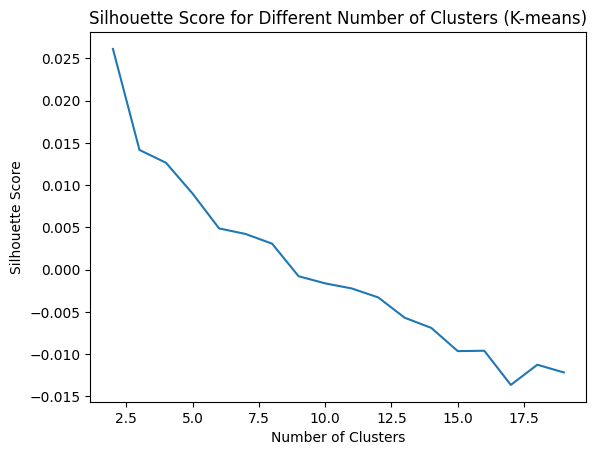

In [25]:
# 결과 출력
plt.plot(result_df_kmeans["n_clusters"], result_df_kmeans["silhouette_score"])
plt.title("Silhouette Score for Different Number of Clusters (K-means)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [26]:
# 위의 실루엣에 따른 적정 cluster개수를 선정해 아래 n_clusters를 조정합니다
model = KMeans(n_clusters = 6)
cluster_info = model.fit_predict(document_vectors)

##### 시각화

In [2]:
import pandas as pd
from gensim.models import Doc2Vec

model_path = '/Users/seungminkoo/Desktop/대학원/프로젝트/HY야쿠르트/2.dcx/2. 클러스터링/doc2vec.model'
d2vmodel = Doc2Vec.load(model_path)
document_vectors = d2vmodel.dv.vectors
data = pd.read_csv('[hy]cluster_fn.csv', encoding = 'utf-8-sig')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

vectors = np.array([d2vmodel.dv[i] for i in range(len(d2vmodel.dv))])

# t-SNE를 사용하여 2D로 차원 축소
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

# 시각화
plt.figure(figsize=(10, 7))
for i in range(6):
    cluster_points = vectors_2d[data['cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}")

plt.legend()
plt.title("K-means Clustering(t-SNE)")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.show()

### 원본 파일 별로 클러스터 부여

In [27]:
informative = pd.read_feather('[hy]info.ftr', columns=None, use_threads=True)

In [29]:
### info 데이터에 군집화 라벨 추가
informative['cluster'] = cluster_info
informative['cluster'].value_counts()

cluster
5    30391
2    16661
3    15916
0    15872
1    14917
4    14196
Name: count, dtype: int64

In [30]:
informative = informative[['review', 'mecab_token', 'cluster']]
informative.to_csv('[hy]cluster_fn.csv', encoding = 'utf-8-sig')

In [31]:
ward0 = informative.loc[informative['cluster'] == 0]
ward1 = informative.loc[informative['cluster'] == 1]
ward2 = informative.loc[informative['cluster'] == 2]
ward3 = informative.loc[informative['cluster'] == 3]
ward4 = informative.loc[informative['cluster'] == 4]
ward5 = informative.loc[informative['cluster'] == 5]

In [32]:
ward0.to_csv('[hy]clu0.csv', encoding = 'utf-8-sig')
ward1.to_csv('[hy]clu1.csv', encoding = 'utf-8-sig')
ward2.to_csv('[hy]clu2.csv', encoding = 'utf-8-sig')
ward3.to_csv('[hy]clu3.csv', encoding = 'utf-8-sig')
ward4.to_csv('[hy]clu4.csv', encoding = 'utf-8-sig')
ward5.to_csv('[hy]clu5.csv', encoding = 'utf-8-sig')

## TF-IDF

In [11]:
# 라이브러리 import

import pandas as pd
import re
from tqdm import tqdm
import numpy as np
from collections import Counter
from tqdm import tqdm

In [ ]:
# 클러스터링 완료된 파일 불러오기

df = pd.read_csv('[hy]cluster_fn.csv',encoding='utf-8-sig', index_col = 0)
df.head()

In [ ]:
df = df[['review', 'target', 'cluster']]
df

In [ ]:
# 특수기호(',' 제거)
def clean_str(text):
    pattern = '[^\w\s]'         #특수기호제거
    text = re.sub(pattern=pattern, repl='', string=text)
    return text 

In [ ]:
tqdm.pandas()
df.review = df.review.progress_apply(clean_str)
df.head()

#### 형태소 분석

In [ ]:
from konlpy.tag import Okt
okt=Okt()  

### 명동형부 main_pos
def postagging(dataframe):
    main_pos = [] # 데이터프레임의 새 컬럼이 될 리스트
    for sentence in tqdm(df['review']): # 리뷰들을 하나씩 가져옴
        pos = okt.pos(sentence, norm=True, stem=True) # 형태소 분석
        main_words = [word_pos[0] for word_pos in pos if word_pos[1] in ('Adjective', #형용사
                                                                         'Noun', #명사
                                                                         'Adjective', #부사
                                                                         'Verb', #동사
                                                                         )] 

        main_words_str = " ".join(main_words) # main_words 리스트 안의 형태소들을 띄어쓰기로 분리된 하나의 문자열로 join
        main_pos.append(main_words_str) # 선택한 형태소들로 이루어진 문자열을 최종 리스트에 추가
        df["main_pos"] = pd.DataFrame(main_pos) # 리스트를 데이터프레임으로 변환해 main_pos라는 컬럼명으로 추가

postagging(df)

In [1]:
import pandas as pd
from tqdm import tqdm

df = pd.read_csv('여기부터.csv', encoding = 'utf-8-sig')

In [ ]:
### 명사 noun
from konlpy.tag import Okt
okt=Okt()  

def postagging2(dataframe):
    noun = [] # 명사 리스트
    for sentence in tqdm(dataframe['main_pos']): 
        pos = okt.pos(sentence) # 형태소 분석
        main_words = [word_pos[0] for word_pos in pos if word_pos[1] in ('Noun')] # 명사
        
        main_words_str = " ".join(main_words) 
        noun.append(main_words_str) 
        dataframe["noun"] = pd.DataFrame(noun) 

postagging2(df)


 48%|█████████████████▍                  | 52104/107953 [09:33<15:07, 61.52it/s]

In [5]:
# df.to_csv('[hy]postagging_archive.csv', encoding = 'utf-8-sig')
import pandas as pd
df = pd.read_csv('[hy]postagging_archive.csv',encoding='utf-8-sig', index_col = 0)
df

,Unnamed: 0,review,cluster,main_pos,noun
0,0,선천적으로 장이 안좋아서 밀가루 음식 번 먹으면 번은 똥방귀 장난아니게 많이 나와 ...,0,선천 안좋다 밀가루 음식 번 먹다 번은 똥 방귀 장난 아니다 나오다 변비 생기 장 ...,선천 밀가루 음식 번 번은 똥 방귀 장난 변비 생기 장 방법 금주 프로바이오틱스 나...
1,1,오늘의 도시락 컬리플라워라이스 볶음밥 밥을인척하는 야채들 젛다좋다 이거 진짜 밥같오...,5,오늘 도시락 컬리 플라워 라이스 볶음밥 밥 인척 야채 젛다좋다 거 진짜 밥 같다 최...,오늘 도시락 컬리 플라워 라이스 볶음밥 밥 인척 야채 젛다좋다 거 진짜 밥 최면 밥...
2,2,돼지력 체력 에 나가는 돼지력 여자야 목표는 키로고 개월 생각하고 있어 정신차리고 ...,2,돼지 체력 나가다 돼지 여자 목표 키 개월 생각 있다 정신차리다 다이어트 하다 체력...,돼지 체력 돼지 여자 목표 키 개월 생각 다이어트 체력 마이너스 운동신경 운동 식단...
3,3,인바디 재볼 수 있는 곳 있나 걍 헬스장 가면 재주나 보건소 보건소는 퇴근하는 시간...,5,인바디 재볼 수 있다 곳 있다 헬스장 가면 재주 보건소 보건소 퇴근 하다 시간 가다...,인바디 재볼 수 곳 헬스장 가면 재주 보건소 보건소 퇴근 시간 보건소 보건소 퇴근 ...
4,4,피부관리 어떻게해요 피부나이는 숨길수없다고 요즘 푸석이고 탄력도 떨어지는 게 ㅜㅜ ...,0,피부관리 어떻다 해 피부 나이 숨다 없다 요즘 탄력 떨어지다 게 관리 필수 들다 뷰...,피부관리 해 피부 나이 요즘 탄력 게 관리 필수 뷰티 저 요즘 뷰티 하나 전 셀티 ...
...,...,...,...,...,...
107948,107948,영양제 먹는 사람 꾸준히 먹는 사람들 이거 효과 있는거 같아 오메가 루테인 비타민 ...,0,양제 먹다 사람 꾸준하다 먹다 사람 거 효과 있다 같다 오메가 루테 비타민 종류 유...,양제 사람 사람 거 효과 오메가 루테 비타민 종류 유산균 등등 주 설문 봄 난 그닥...
107949,107949,대학병원에서 영양제 추천해주는 거 대병 외래에서 교수님이 영양제 추천해주는거 말야 ...,1,대학병원 양제 추천 해주다 거 병 외래 교수 양제 추천 해주다 말 처방 말다 밖 구...,대학병원 양제 추천 거 병 외래 교수 양제 추천 말 처방 밖 구입 보통 안과 루테 ...
107950,107950,괜찮은 영양제 추천해주세요 요즘 영양제에 관심 가지게 되었는데 영양제 종류가 너무 ...,0,괜찮다 양제 추천 해주다 요즘 양제 관심 가지 되어다 양제 종류 많다 우선 안구건조...,양제 추천 요즘 양제 관심 가지 양제 종류 우선 안구건조증 루테 사유 포함 양제 혹...
107951,107951,눈 묵직하고 침침하면 뭐 챙겨 먹어야돼 대 중반인데 요즘 눈이 묵직하고 침침한게 좀...,5,눈 묵직하다 침침하다 뭐 챙기다 먹다 돼다 대다 중반 요즘 눈 묵직하다 침침하다 좀...,눈 뭐 중반 요즘 눈 좀 피로 감 시력 라식 느낌 저녁 거의 앞 안보 운전 루테 사...


In [6]:
df = df[['review', 'cluster', 'main_pos', 'noun']]

#### 클러스터에 넣기

In [7]:
from tqdm import tqdm

tqdm.pandas()
df["pos"] = df["main_pos"].progress_apply(lambda x : x.split())
df["pos"]

100%|████████████████████████████████| 107953/107953 [00:01<00:00, 75574.38it/s]


0         [선천, 안좋다, 밀가루, 음식, 번, 먹다, 번은, 똥, 방귀, 장난, 아니다, ...
1         [오늘, 도시락, 컬리, 플라워, 라이스, 볶음밥, 밥, 인척, 야채, 젛다좋다, ...
2         [돼지, 체력, 나가다, 돼지, 여자, 목표, 키, 개월, 생각, 있다, 정신차리다...
3         [인바디, 재볼, 수, 있다, 곳, 있다, 헬스장, 가면, 재주, 보건소, 보건소,...
4         [피부관리, 어떻다, 해, 피부, 나이, 숨다, 없다, 요즘, 탄력, 떨어지다, 게...
                                ...                        
107948    [양제, 먹다, 사람, 꾸준하다, 먹다, 사람, 거, 효과, 있다, 같다, 오메가,...
107949    [대학병원, 양제, 추천, 해주다, 거, 병, 외래, 교수, 양제, 추천, 해주다,...
107950    [괜찮다, 양제, 추천, 해주다, 요즘, 양제, 관심, 가지, 되어다, 양제, 종류...
107951    [눈, 묵직하다, 침침하다, 뭐, 챙기다, 먹다, 돼다, 대다, 중반, 요즘, 눈,...
107952    [양제, 조언, 부탁드리다, 의사, 약사, 제약, 선생님, 환영, 안녕하다, 평소,...
Name: pos, Length: 107953, dtype: object

In [8]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in tqdm(range(len(df["cluster"]))):
    if df['cluster'][i] == 0:
        for e in df["pos"][i]:
            cluster0.append(e)
            
    elif df['cluster'][i] == 1:
        for e in df["pos"][i]:
            cluster1.append(e)
                
    elif df['cluster'][i] == 2:
        for e in df["pos"][i]:
            cluster2.append(e)
            
    elif df['cluster'][i] == 3:
        for e in df["pos"][i]:
            cluster3.append(e)
                
    elif df['cluster'][i] == 4:
        for e in df["pos"][i]:
            cluster4.append(e)

    elif df['cluster'][i] == 5:
        for e in df["pos"][i]:
            cluster5.append(e)

100%|████████████████████████████████| 107953/107953 [00:03<00:00, 31032.01it/s]


In [9]:
everything = []
for i in df["pos"]:
    for w in i:
        everything.append(w)
everything

['선천',
 '안좋다',
 '밀가루',
 '음식',
 '번',
 '먹다',
 '번은',
 '똥',
 '방귀',
 '장난',
 '아니다',
 '나오다',
 '변비',
 '생기',
 '장',
 '좋아지다',
 '방법',
 '있다',
 '금주',
 '프로바이오틱스',
 '나',
 '술',
 '먹다',
 '밀가루',
 '음식',
 '줄이다',
 '되다',
 '양배추',
 '즙',
 '먹다',
 '진짜',
 '정석',
 '유산균',
 '꾸준하다',
 '먹다',
 '채소',
 '먹다',
 '좋아지다',
 '글속',
 '답',
 '나오다',
 '요새',
 '절',
 '밥스',
 '일로',
 '밥',
 '해',
 '먹다',
 '확실하다',
 '배',
 '가볍다',
 '가스',
 '차다',
 '메',
 '디락',
 '디',
 '에스',
 '장용',
 '캡슐',
 '강추',
 '오늘',
 '도시락',
 '컬리',
 '플라워',
 '라이스',
 '볶음밥',
 '밥',
 '인척',
 '야채',
 '젛다좋다',
 '거',
 '진짜',
 '밥',
 '같다',
 '최면',
 '걸다',
 '밥',
 '같다',
 '짐',
 '아니다',
 '식',
 '감다',
 '맛',
 '우왓',
 '이쁘다',
 '이쁘다',
 '맛있다',
 '자다',
 '챙겨먹넼',
 '마싯다',
 '따다',
 '돼지',
 '체력',
 '나가다',
 '돼지',
 '여자',
 '목표',
 '키',
 '개월',
 '생각',
 '있다',
 '정신차리다',
 '다이어트',
 '하다',
 '체력',
 '마이너스',
 '운동신경',
 '없다',
 '운동',
 '식단',
 '어떻다',
 '하다',
 '좋다',
 '무엇',
 '조언',
 '해주다',
 '고맙다',
 '일단',
 '실현',
 '가능하다',
 '목표',
 '먼저',
 '세우다',
 '글',
 '보다',
 '애',
 '은',
 '무리하다',
 '목표',
 '같다',
 '급격하다',
 '체중',
 '증가',
 '이다',
 '모르다',
 '원래',
 '그',
 '정도',
 '

#### TF-IDF 계산

In [13]:
# 빈도 계산
# 클러 개수 맞춰서 counts 만들기
counts0 = Counter(cluster0)
counts1 = Counter(cluster1)
counts2 = Counter(cluster2)
counts3 = Counter(cluster3)
counts4 = Counter(cluster4)
counts5 = Counter(cluster5)
everything_counts = Counter(everything)

# 각 단어가 몇 개의 클러스터에서 등장하는지 기록
count_list = [counts0, counts1, counts2, counts3, counts4, counts5]

# 모든 단어의 리스트
all_words = list(everything_counts.keys())

In [15]:
# 단어가 몇 개의 클러스터에서 등장하는지 계산
cluster_counts = {word: 0 for word in all_words}
for counts in count_list:
    for word in counts.keys():
        cluster_counts[word] += 1

# DataFrame으로 변환
dic = pd.DataFrame.from_dict(cluster_counts, orient='index', columns=['num_clusters'])

In [16]:
# TF-IDF 계산
tfidf_list = []
for counts in tqdm(count_list):
    tfidf_cluster = {w: counts[w] / np.exp(dic.loc[w, 'num_clusters']) if dic.loc[w, 'num_clusters'] < 6 else 0 for w in counts.keys()}
    tfidf_list.append(tfidf_cluster)

# TF-IDF 값 확인 (요약된 출력)
for i, tfidf in enumerate(tfidf_list):
    print(f"Cluster {i} TF-IDF (first few items):", {k: tfidf[k] for k in list(tfidf)[:5]})

100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.88it/s]

Cluster 0 TF-IDF (first few items): {'선천': 0, '안좋다': 0, '밀가루': 0, '음식': 0, '번': 0}
Cluster 1 TF-IDF (first few items): {'보약': 0, '효과': 0, '있다': 0, '남편': 0, '요즘': 0}
Cluster 2 TF-IDF (first few items): {'돼지': 0, '체력': 0, '나가다': 0, '여자': 0, '목표': 0}
Cluster 3 TF-IDF (first few items): {'집밥': 0, '타다': 0, '반찬': 0, '사진': 0, '마구': 0}
Cluster 4 TF-IDF (first few items): {'오늘': 0, '운동': 0, '일기': 0, '멸치': 0, '살찌다': 0}
Cluster 5 TF-IDF (first few items): {'오늘': 0, '도시락': 0, '컬리': 0, '플라워': 0, '라이스': 0}


In [17]:
tfidf_list

[{'선천': 0,
  '안좋다': 0,
  '밀가루': 0,
  '음식': 0,
  '번': 0,
  '먹다': 0,
  '번은': 0,
  '똥': 0,
  '방귀': 0,
  '장난': 0,
  '아니다': 0,
  '나오다': 0,
  '변비': 0,
  '생기': 0,
  '장': 0,
  '좋아지다': 0,
  '방법': 0,
  '있다': 0,
  '금주': 0,
  '프로바이오틱스': 0,
  '나': 0,
  '술': 0,
  '줄이다': 0,
  '되다': 0,
  '양배추': 0,
  '즙': 0,
  '진짜': 0,
  '정석': 0,
  '유산균': 0,
  '꾸준하다': 0,
  '채소': 0,
  '글속': 0.006737946999085467,
  '답': 0,
  '요새': 0,
  '절': 0,
  '밥스': 0.8463801622536871,
  '일로': 0,
  '밥': 0,
  '해': 0,
  '확실하다': 0,
  '배': 0,
  '가볍다': 0,
  '가스': 0,
  '차다': 0,
  '메': 0,
  '디락': 0,
  '디': 0,
  '에스': 0,
  '장용': 0,
  '캡슐': 0,
  '강추': 0,
  '피부관리': 0,
  '어떻다': 0,
  '피부': 0,
  '나이': 0,
  '숨다': 0,
  '없다': 0,
  '요즘': 0,
  '탄력': 0,
  '떨어지다': 0,
  '게': 0,
  '관리': 0,
  '필수': 0,
  '들다': 0,
  '뷰티': 0,
  '챙기다': 0,
  '저': 0,
  '보다': 0,
  '맞다': 0,
  '하나': 0,
  '전': 0,
  '셀티': 0.036631277777468364,
  '엘라': 0.16844867497713667,
  '콜라겐': 0,
  '포': 0,
  '엘라스': 1.4149688698079481,
  '틴': 0,
  '기도': 0,
  '쉬다': 0,
  '개선': 0,
  '하니': 0,
  '좋다': 0,

In [18]:
# DataFrame으로 변환 (선택 사항)
tfidf_dfs = []
for i, tfidf in enumerate(tfidf_list):
    df = pd.DataFrame(list(tfidf.items()), columns=['단어', f'tfidf{i}']).sort_values(by=f'tfidf{i}', ascending=False).reset_index(drop=True)
    tfidf_dfs.append(df)

# Display one of the DataFrames (요약된 출력)
print(tfidf_dfs[0].head())

    단어     tfidf0
0  루이비  44.513412
1   루셀  30.044433
2  앤숄더  26.119710
3  설화수  24.089680
4   루톤  19.497610


In [33]:
# TF-IDF값 스케일링

scaler = MinMaxScaler()

for i, df in enumerate(tfidf_dfs):
    tfidf_column = f'tfidf{i}'
    df[[tfidf_column]] = scaler.fit_transform(df[[tfidf_column]])
    tfidf_dfs[i] = df

In [34]:
tfidf0 = tfidf_dfs[0]
tfidf1 = tfidf_dfs[1]
tfidf2 = tfidf_dfs[2]
tfidf3 = tfidf_dfs[3]
tfidf4 = tfidf_dfs[4]
tfidf5 = tfidf_dfs[5]

In [35]:
tfidf0

,단어,tfidf0
0,루이비,1.000000
1,루셀,0.674952
2,앤숄더,0.586783
3,설화수,0.541178
4,루톤,0.438017
...,...,...
39777,위경련,0.000000
39778,티어,0.000000
39779,소만,0.000000
39780,일체,0.000000


In [36]:
tfidf0.to_csv('[hy]TF-IDF_clu0.csv', encoding = 'utf-8-sig')
tfidf1.to_csv('[hy]TF-IDF_clu1.csv', encoding = 'utf-8-sig')
tfidf2.to_csv('[hy]TF-IDF_clu2.csv', encoding = 'utf-8-sig')
tfidf3.to_csv('[hy]TF-IDF_clu3.csv', encoding = 'utf-8-sig')
tfidf4.to_csv('[hy]TF-IDF_clu4.csv', encoding = 'utf-8-sig')
tfidf5.to_csv('[hy]TF-IDF_clu5.csv', encoding = 'utf-8-sig')